In [ ]:
# --- Section 1: Imports & Configuration ---
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops, ImageEnhance
from io import BytesIO
from tqdm import tqdm  # For progress bars

# TensorFlow / Keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30
# Update these paths to match your folder structure
PATH_AUTHENTIC = '../CASIA2/Au' 
PATH_TAMPERED = '../CASIA2/Tp'
# Model save path
MODEL_SAVE_PATH = "../models/mobilenet_forgery_model_v2.0.h5" # New version Model saved here, previously v1.0.h5 

In [2]:
# --- Section 2: ELA Conversion Function ---
def convert_to_ela_image(path, quality=90):
    """
    Converts an image to its Error Level Analysis (ELA) representation.
    Returns a PIL Image object.
    """
    try:
        # Open image and convert to RGB (strips alpha channels if present)
        image = Image.open(path).convert('RGB')
        
        # Save to memory buffer instead of disk (faster)
        buffer = BytesIO()
        image.save(buffer, 'JPEG', quality=quality)
        buffer.seek(0)
        resaved_image = Image.open(buffer)
        
        # Calculate pixel difference
        ela_image = ImageChops.difference(image, resaved_image)
        
        # Maximize the difference to make artifacts visible
        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        
        return ela_image
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

In [3]:
# --- Section 3: Data Preparation ---

X = []
Y = []

def prepare_data(path, class_label, limit=None):
    """
    Loads images, converts them to ELA, and appends to X and Y.
    limit: Optional integer to limit the number of images (for testing RAM).
    """
    print(f"Processing folder: {path} (Label: {class_label})")
    
    files = os.listdir(path)
    if limit:
        files = files[:limit]
        
    for filename in tqdm(files):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
            img_path = os.path.join(path, filename)
            ela_img = convert_to_ela_image(img_path)
            
            if ela_img is not None:
                # Resize to (128, 128) to match model input
                ela_img = ela_img.resize(IMG_SIZE)
                
                # Convert to numpy array
                ela_array = np.array(ela_img)
                
                X.append(ela_array)
                Y.append(class_label)

# Load Data (Adjust the limit if you have Memory issues, or set to None for full dataset)
prepare_data(PATH_AUTHENTIC, 0, limit=8000) # 0 = Authentic
prepare_data(PATH_TAMPERED, 1, limit=7000)  # 1 = Tempered

# Convert to Numpy Arrays
X = np.array(X)
Y = to_categorical(Y, 2)  # One-hot encoding

# --- KEY FIX: MobileNetV2 Preprocessing ---
# This converts 0-255 pixel values to -1 to 1 range
print("Applying MobileNetV2 Preprocessing...")
X = preprocess_input(X)

# Split Data
# Stratify ensures we have a balanced mix of Authentic/Tampered in both sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Processing folder: ../CASIA2/Au (Label: 0)


  0%|          | 0/7492 [00:00<?, ?it/s]

100%|██████████| 7492/7492 [02:44<00:00, 45.45it/s] 


Processing folder: ../CASIA2/Tp (Label: 1)


100%|██████████| 5125/5125 [01:51<00:00, 45.95it/s]


Applying MobileNetV2 Preprocessing...
Training shape: (10048, 128, 128, 3)
Validation shape: (2512, 128, 128, 3)


In [4]:
# --- Section 4: Build MobileNetV2 Model ---

def build_mobilenet_model():
    # 1. Load Base Model (Pre-trained on ImageNet)
    # include_top=False drops the final classification layer
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(128, 128, 3)
    )
    
    # 2. Freeze Base Model
    # We only want to train the new layers at the top first
    base_model.trainable = False 
    
    # 3. Add Custom Head for Forgery Detection
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Condenses feature maps
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)             # Prevents overfitting
    predictions = Dense(2, activation='softmax')(x) # Output: [Authentic, Tempered]
    
    # 4. Compile
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Use a lower learning rate for transfer learning
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

model = build_mobilenet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# --- Section 5: Training ---

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,             # Reduce LR by 80% if stuck
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Start Training
history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Save the updated model
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 166s 486ms/step - accuracy: 0.7588 - loss: 0.5252 - val_accuracy: 0.8340 - val_loss: 0.3638 - learning_rate: 1.0000e-04
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 129s 412ms/step - accuracy: 0.8391 - loss: 0.3767 - val_accuracy: 0.8400 - val_loss: 0.3475 - learning_rate: 1.0000e-04
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 130s 413ms/step - accuracy: 0.8546 - loss: 0.3452 - val_accuracy: 0.8555 - val_loss: 0.3350 - learning_rate: 1.0000e-04
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 133s 424ms/step - accuracy: 0.8619 - loss: 0.3242 - val_accuracy: 0.8571 - val_loss: 0.3220 - learning_rate: 1.0000e-04
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 115s 364ms/step - accuracy: 0.8661 - loss: 0.3137 - val_accuracy: 0.8599 - val_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 116s 368ms/step - accuracy: 0.8733 - loss: 0.3009 - val_accuracy: 0.8615 - val_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 

Model saved successfully.


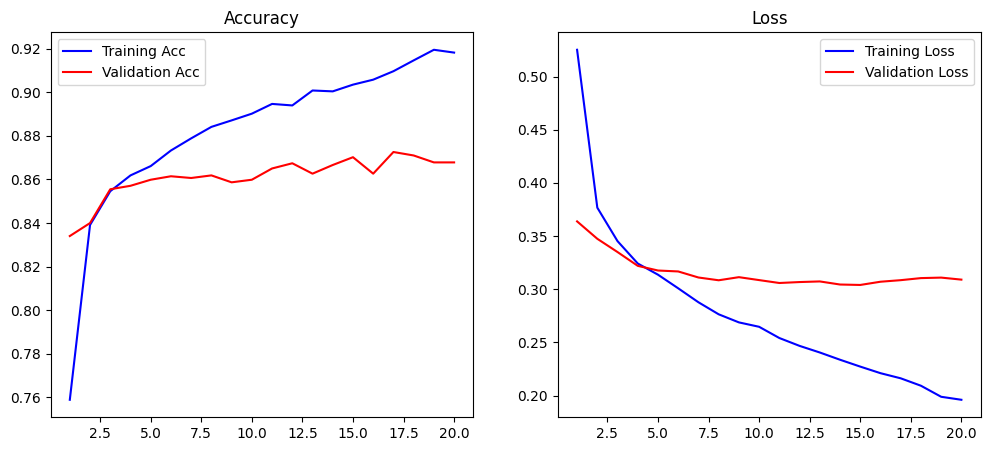

Generating evaluation metrics...
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.91      0.86      0.89      1487
    Tempered       0.82      0.88      0.85      1025

    accuracy                           0.87      2512
   macro avg       0.86      0.87      0.87      2512
weighted avg       0.87      0.87      0.87      2512



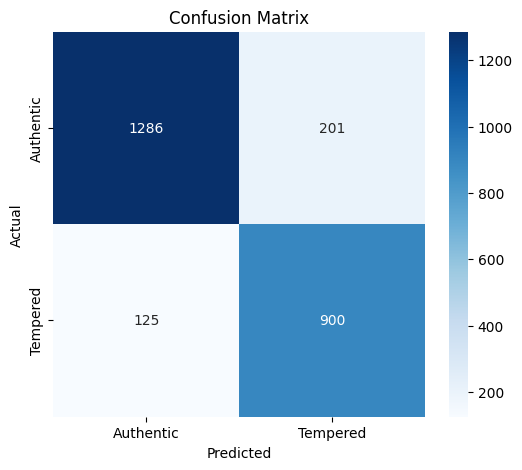

In [6]:
# --- Section 6: Evaluation & Metrics ---

# 1. Plot Accuracy & Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

# 2. Confusion Matrix & Report
print("Generating evaluation metrics...")
Y_pred_probs = model.predict(X_val)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = np.argmax(Y_val, axis=1)

print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=['Authentic', 'Tempered']))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(Y_true, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Authentic', 'Tempered'], 
            yticklabels=['Authentic', 'Tempered'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Result: Tempered (91.90%)


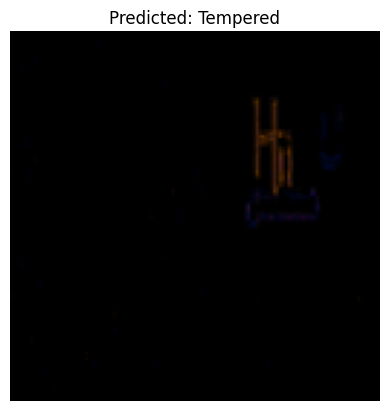

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Result: Tempered (84.24%)


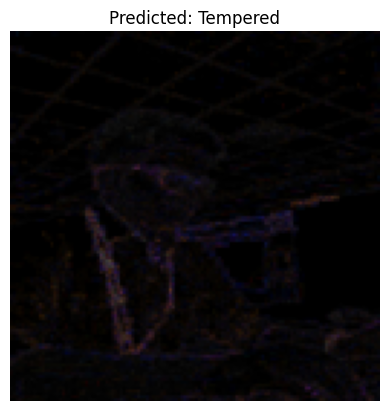

In [10]:
# --- Section 7: Test Single Image ---

def test_image(model, image_path):
    # 1. Convert to ELA
    ela_img = convert_to_ela_image(image_path, quality=90)
    
    if ela_img is not None:
        # 2. Resize
        ela_img = ela_img.resize(IMG_SIZE)
        
        # 3. Preprocess for MobileNetV2
        # (Convert to array -> expand dims -> preprocess_input)
        img_array = np.array(ela_img)
        img_array = np.expand_dims(img_array, axis=0) # Shape becomes (1, 128, 128, 3)
        img_array = preprocess_input(img_array)       # Scales to [-1, 1]
        
        # 4. Predict
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        label = "Tempered" if class_idx == 1 else "Authentic"
        
        print(f"Result: {label} ({confidence:.2f}%)")
        
        plt.imshow(ela_img)
        plt.axis('off')
        plt.title(f"Predicted: {label}")
        plt.show()
    else:
        print("Error: Could not process image.")


TEST_IMAGE = "C:\\Users\\Nikhil\\Pictures\\Camera Roll\\edited.jpg"
TEST_IMAGE_1 = "C:\\Users\\Nikhil\\Pictures\\Camera Roll\\test1.jpg"
# Example Usage
test_image(model, TEST_IMAGE)
test_image(model, TEST_IMAGE_1)